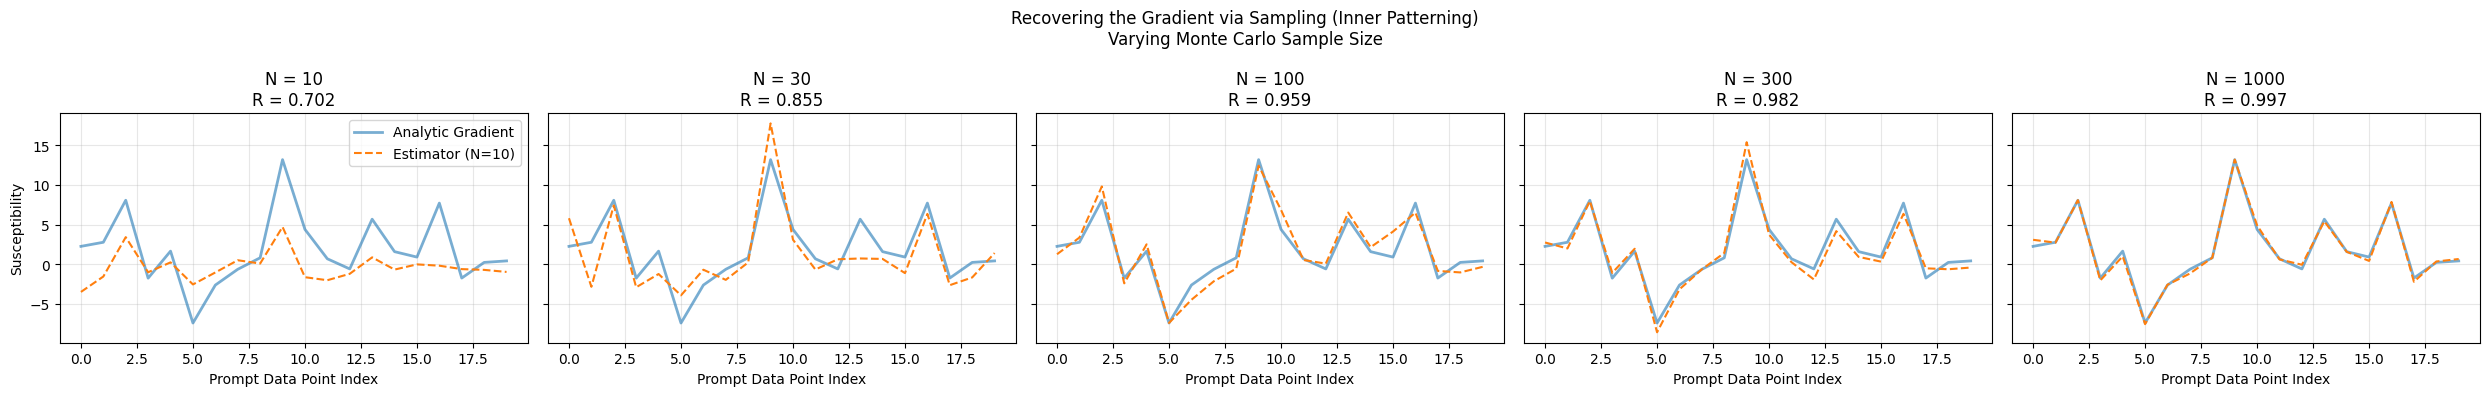

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

# 1. Setup (Same as before)
# -------------------------
d = 10
n_prompt = 20
reg_lambda = 1.0
target_val = 15.0

# Different Monte Carlo sample sizes to compare
sample_sizes = [10, 30, 100, 300, 1000]

torch.manual_seed(42)

# Create Data
X_prompt = torch.randn(n_prompt, d)
true_theta = torch.randn(d, 1)
Y_prompt = X_prompt @ true_theta + 0.1 * torch.randn(n_prompt, 1)
x_query = torch.randn(d, 1)

# ---------------------------------------------------------
# METHOD A: The "Analytic" Ground Truth (Calculus)
# ---------------------------------------------------------
X_p = X_prompt.clone().requires_grad_(True)
Y_p = Y_prompt.clone().requires_grad_(True)

# Exact Posterior
XT_X = X_p.T @ X_p
precision = XT_X + reg_lambda * torch.eye(d)
Sigma_inv = torch.inverse(precision)  # this is actually the covariance
mu_post = Sigma_inv @ X_p.T @ Y_p

# Exact Prediction & Utility
y_pred_exact = x_query.T @ mu_post
U_exact = -(y_pred_exact - target_val)**2
U_exact.backward()

true_grad_Y = Y_p.grad.detach().flatten()  # shape: (n_prompt,)

# ---------------------------------------------------------
# METHOD B: Covariance Estimator for different sample sizes
# ---------------------------------------------------------

fig, axes = plt.subplots(
    1, len(sample_sizes),
    figsize=(5 * len(sample_sizes), 4),
    sharey=True
)

if len(sample_sizes) == 1:
    axes = [axes]  # make it iterable

for ax, num_samples in zip(axes, sample_sizes):
    # 1. Draw Samples from the Posterior p(theta | Prompt)
    post_dist = MultivariateNormal(mu_post.detach().squeeze(), Sigma_inv.detach())
    theta_samples = post_dist.sample((num_samples,))  # Shape: (N, d)

    # 2. Calculate F(theta) - The Utility for each sample
    preds_sample = theta_samples @ x_query  # Shape: (N, 1)
    utilities = -(preds_sample - target_val)**2  # Shape: (N, 1)

    # 3. Calculate Score - Gradient of Log Likelihood w.r.t Prompt Y
    # Y_prompt: (n_prompt, 1)
    # Preds on prompt: (N, n_prompt) = theta_samples @ X_prompt.T
    preds_on_prompt = theta_samples @ X_prompt.detach().T  # (N, n_prompt)
    residuals = Y_prompt.detach().T - preds_on_prompt      # (1, n_prompt) - (N, n_prompt)

    # For Gaussian noise sigma=1, Grad_y log p = -(y - x@theta)
    scores_Y = -residuals  # Shape: (N, n_prompt)

    # 4. Compute Covariance
    F_centered = utilities - utilities.mean()                  # (N, 1)
    S_centered = scores_Y - scores_Y.mean(dim=0)               # (N, n_prompt)

    estimated_grad_Y = (F_centered * S_centered).mean(dim=0)   # (n_prompt,)
    estimated_grad_Y = estimated_grad_Y.flatten()

    # Correlation
    corr = torch.corrcoef(
        torch.stack((true_grad_Y, estimated_grad_Y))
    )[0, 1].item()

    # Plot
    ax.plot(true_grad_Y.numpy(), label='Analytic Gradient', linewidth=2, alpha=0.6)
    ax.plot(estimated_grad_Y.numpy(), '--', label=f'Estimator (N={num_samples})', linewidth=1.5)

    ax.set_title(f"N = {num_samples}\nR = {corr:.3f}")
    ax.set_xlabel("Prompt Data Point Index")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Susceptibility")
axes[0].legend(loc='best')

plt.suptitle("Recovering the Gradient via Sampling (Inner Patterning)\nVarying Monte Carlo Sample Size")
plt.tight_layout()
plt.show()


Target: 15.0 | Elastic Net (L1=2.0, L2=2.0)
Running Patterning Loop...

Final Prediction: 5.8082
Max Perturbation: 3.6623
Sparsity: 14 points unchanged.


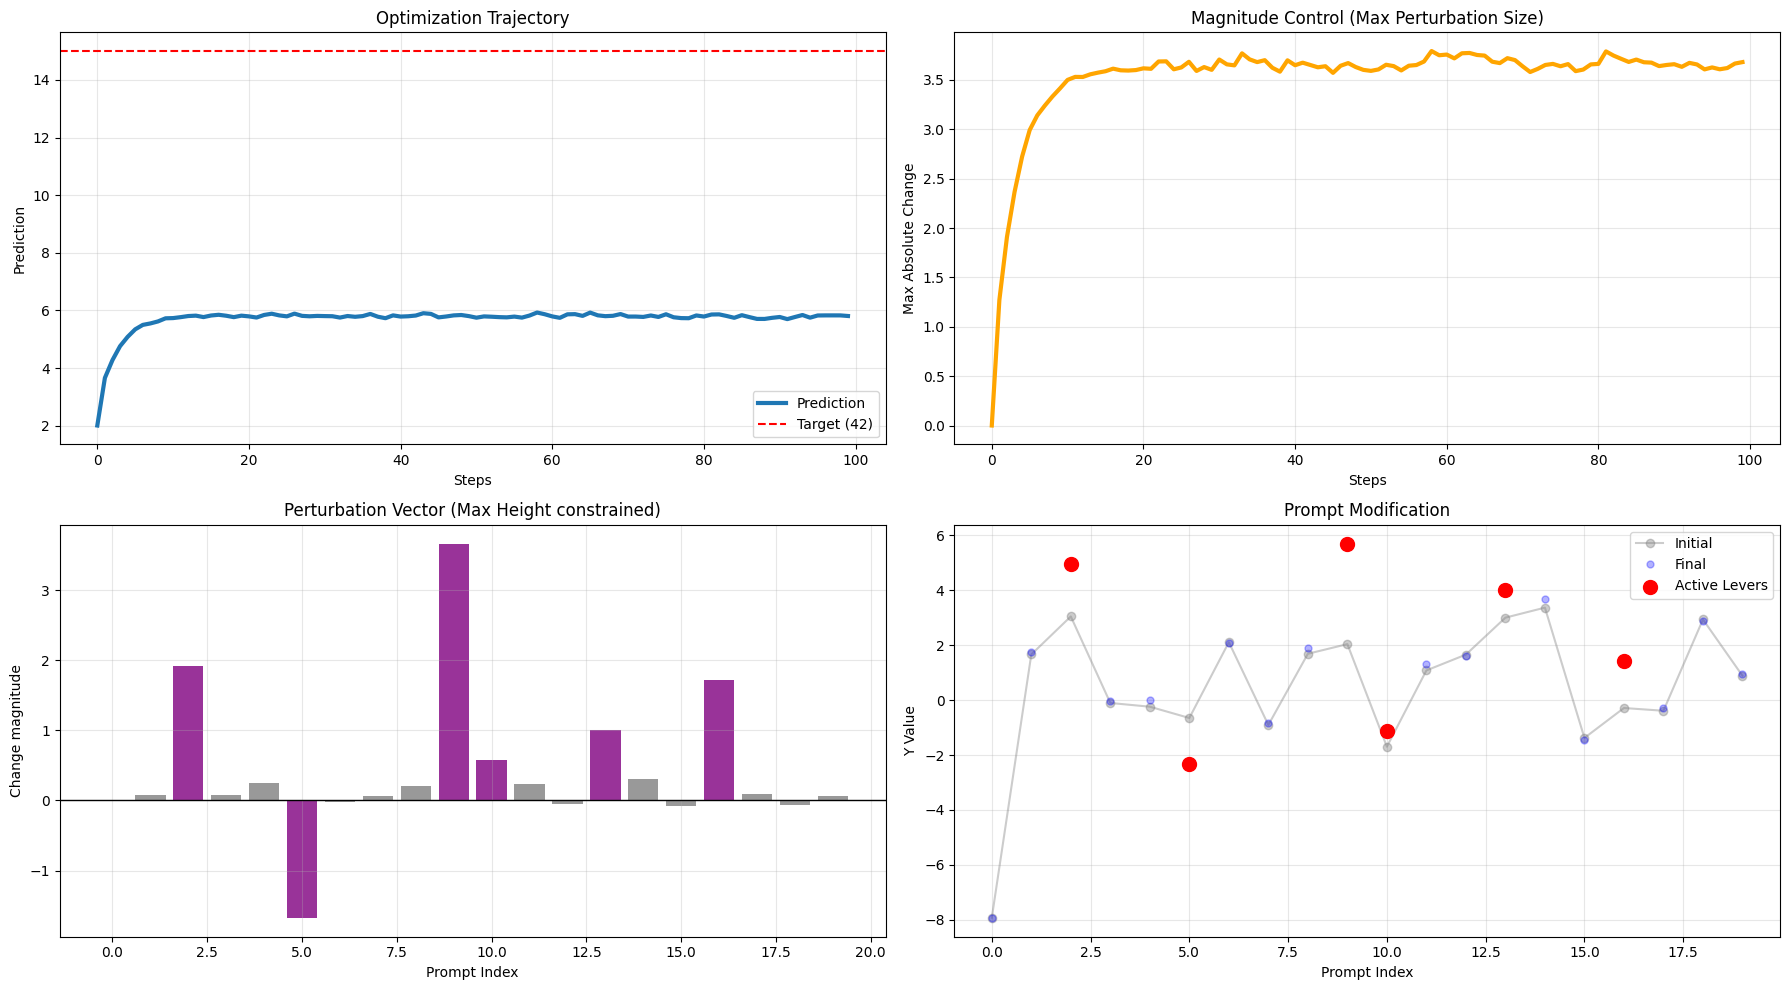

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

# --- Setup ---
d = 10
n_prompt = 20
reg_lambda = 1.0
target_val = 15.0
num_samples = 2000
learning_rate = 0.1
num_steps = 100

# HYPERPARAMETERS FOR THE "GOLDIELOCKS" ZONE
l1_penalty = 2.0   # The Friction (Forces Zeros)
l2_penalty = 2.0   # The Spring (Prevents Spikes)

torch.manual_seed(42)

# --- Initialize Data ---
X_prompt = torch.randn(n_prompt, d)
true_theta = torch.randn(d, 1)
Y_initial = X_prompt @ true_theta + 0.1 * torch.randn(n_prompt, 1)

Y_optimized = Y_initial.clone()
x_query = torch.randn(d, 1)

prediction_trajectory = []
perturbation_max_trajectory = []

print(f"Target: {target_val} | Elastic Net (L1={l1_penalty}, L2={l2_penalty})")
print("Running Patterning Loop...")

for step in range(num_steps):
    # 1. Forward Pass
    XT_X = X_prompt.T @ X_prompt
    precision = XT_X + reg_lambda * torch.eye(d)
    Sigma_inv = torch.inverse(precision)
    mu_post = Sigma_inv @ X_prompt.T @ Y_optimized

    # Metrics
    current_pred = (x_query.T @ mu_post).item()
    # Track the SIZE of the biggest lie (L-infinity norm roughly)
    max_pert = torch.max(torch.abs(Y_optimized - Y_initial)).item()

    prediction_trajectory.append(current_pred)
    perturbation_max_trajectory.append(max_pert)

    # 2. Covariance Estimation
    post_dist = MultivariateNormal(mu_post.squeeze(), Sigma_inv)
    theta_samples = post_dist.sample((num_samples,))

    preds_sample = theta_samples @ x_query
    utilities = -(preds_sample - target_val)**2

    preds_on_prompt = theta_samples @ X_prompt.T
    scores_Y = -(Y_optimized.T - preds_on_prompt)

    F_centered = utilities - utilities.mean()
    S_centered = scores_Y - scores_Y.mean(dim=0)
    chi_in = (F_centered * S_centered).mean(dim=0).unsqueeze(1)

    # 3. Elastic Net Update
    perturbation = Y_optimized - Y_initial

    # L1 Gradient (Sign) - Sparsity
    l1_grad = l1_penalty * torch.sign(perturbation)

    # L2 Gradient (Linear) - Magnitude Control
    l2_grad = l2_penalty * perturbation

    # Combined Update
    Y_optimized.data += learning_rate * (chi_in - l1_grad - l2_grad)

    # Optional: Hard Clip (Safety rail)
    # perturbation = torch.clamp(Y_optimized - Y_initial, -10, 10)
    # Y_optimized.data = Y_initial + perturbation

# --- Analysis ---
final_perturbation = Y_optimized - Y_initial
# Filter for significant movers
active_indices = torch.where(torch.abs(final_perturbation) > 0.5)[0]
sparsity_count = n_prompt - len(active_indices)

print(f"\nFinal Prediction: {prediction_trajectory[-1]:.4f}")
print(f"Max Perturbation: {torch.max(torch.abs(final_perturbation)):.4f}")
print(f"Sparsity: {sparsity_count} points unchanged.")

# --- Visualization ---
fig, ax = plt.subplots(2, 2, figsize=(18, 10))

# Plot 1: Prediction Trajectory
ax[0, 0].plot(prediction_trajectory, linewidth=3, label='Prediction')
ax[0, 0].axhline(y=target_val, color='r', linestyle='--', label='Target (42)')
ax[0, 0].set_title("Optimization Trajectory")
ax[0, 0].set_xlabel("Steps")
ax[0, 0].set_ylabel("Prediction")
ax[0, 0].legend()
ax[0, 0].grid(True, alpha=0.3)

# Plot 2: Max Perturbation (The "Hugeness" Check)
ax[0, 1].plot(perturbation_max_trajectory, linewidth=3, color='orange', label='Max |Change|')
ax[0, 1].set_title("Magnitude Control (Max Perturbation Size)")
ax[0, 1].set_xlabel("Steps")
ax[0, 1].set_ylabel("Max Absolute Change")
ax[0, 1].grid(True, alpha=0.3)

# Plot 3: The Fingerprint (Elastic Net Style)
# Should see "stumps" rather than "skyscrapers"
colors = ['grey' if i not in active_indices else 'purple' for i in range(n_prompt)]
ax[1, 0].bar(range(n_prompt), final_perturbation.flatten().numpy(), color=colors, alpha=0.8)
ax[1, 0].set_title(f"Perturbation Vector (Max Height constrained)")
ax[1, 0].set_xlabel("Prompt Index")
ax[1, 0].set_ylabel("Change magnitude")
ax[1, 0].axhline(0, color='black', linewidth=1)
ax[1, 0].grid(True, alpha=0.3)

# Plot 4: Before vs After
ax[1, 1].plot(Y_initial.numpy(), 'o-', label='Initial', alpha=0.4, color='grey')
Y_active = Y_initial.clone()
Y_active[active_indices] = Y_optimized[active_indices]
ax[1, 1].plot(Y_optimized.numpy(), 'o', label='Final', color='blue', alpha=0.3, markersize=5)
ax[1, 1].scatter(active_indices, Y_optimized[active_indices], color='red', s=100, label='Active Levers', zorder=5)

ax[1, 1].set_title("Prompt Modification")
ax[1, 1].set_xlabel("Prompt Index")
ax[1, 1].set_ylabel("Y Value")
ax[1, 1].legend()
ax[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()